# Group Project / Assignment 3: Retrieval-Augmented Generation Question Answering
**Assignment due 6 April 11:59pm 2025**

Welcome to the third assignment for 50.055 Machine Learning Operations. 
The third and fourth assignment together form the course group project. You will be working in your project groups to build a chatbot which can answer questions about SUTD to prospective students.


**This assignment is a group assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment. If you work on another environment, minimally test your work on the SUTD Education Cluster.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. Creativity and innovation: in this assignment you have more freedom to design your solution, compared to the first assignments. You can show of your creativity and innovative mindset. 
6. There is a maximum of 225 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission instructions are located at the bottom of the notebook.



### Retrieval-Augmented Generation (RAG) 

In this assignment, you will be building a Retrieval-Augmented Generation (RAG) question answering system which can answer questions about SUTD.

We'll be leveraging `langchain` and `llama 3.2`.

Check out the docs:
- [LangChain](https://docs.langchain.com/docs/)
- [Llama 3.2](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2/)


The SUTD website used to allow chatting with current students. Unfortunately, this feature does not exist anymore. Let's build a chatbot to fill this gap!


### Conduct user research

What are the questions that prospective and current students have about SUTD? In week 2, you already conducted some user research to understand your users.

### Value Proposition Canvas


### QUESTION: 

Paste the value proposition canvas which you have created in week 2 into this notebook below. 


**--- ADD YOUR SOLUTION HERE (10 points) ---**

- (replace canvas image below)

------------------------------


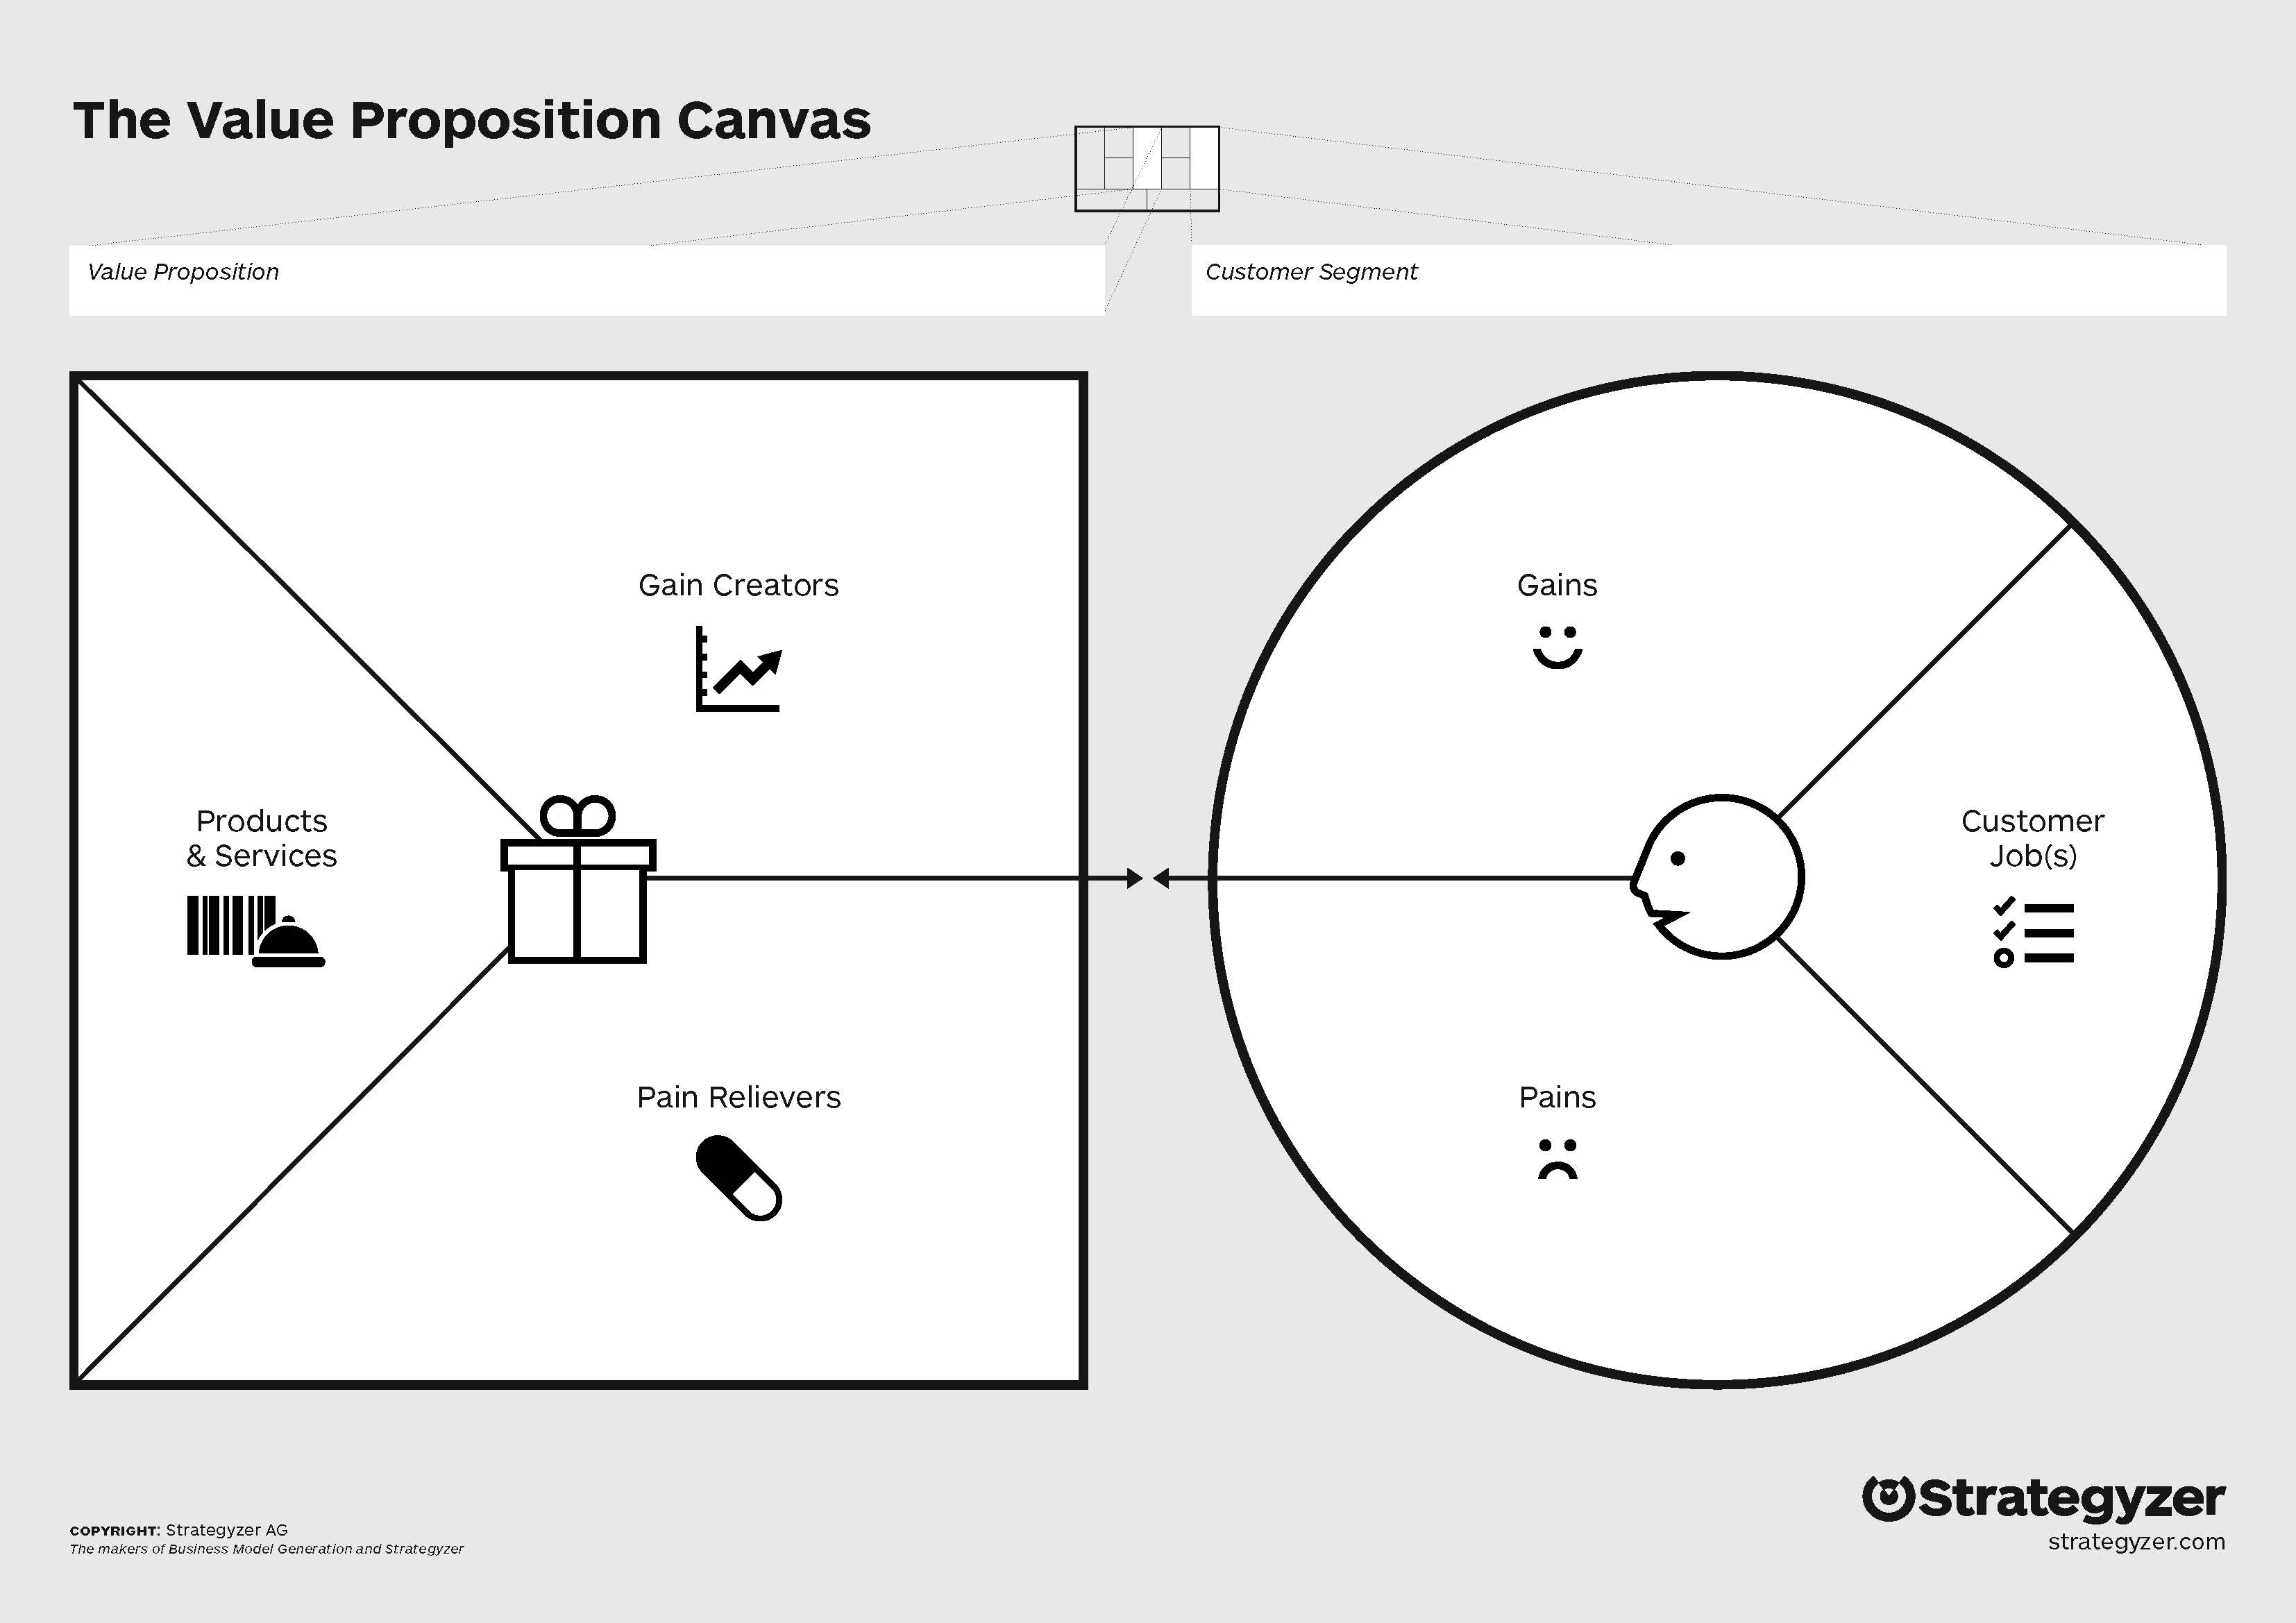

# Install dependencies
Use pip to install all required dependencies of this assignment in the cell below. Make sure to test this on the SUTD cluster as different environments have different software pre-installed.  

In [18]:
# QUESTION: Install and import all required packages
# The rest of your code should execute without any import or dependency errors.

# **--- ADD YOUR SOLUTION HERE (10 points) ---**
# ! pip install langchain chromadb transformers accelerate sentence-transformers pymupdf bs4

from langchain.document_loaders import PyMuPDFLoader, WebBaseLoader, UnstructuredHTMLLoader
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma, FAISS
from langchain.vectorstores.base import VectorStoreRetriever
# from langchain.llms import HuggingFacePipeline
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

from nltk.tokenize import sent_tokenize
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from huggingface_hub import login

import os
import re
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, urlunparse
import inflect
from concurrent.futures import ThreadPoolExecutor, as_completed
# ----------------

# Download documents
The RAG application should be able to answer questions based on ingested documents. For the SUTD chatbot, download PDF and HTML files from the SUTD website. The documents should contain information about the admission process, available courses and the university in general.


In [2]:
# QUESTION: Download documents from the SUTD website
# You should download at least 10 documents but more documents can increase the knowledge base of your chatbot.

# **--- ADD YOUR SOLUTION HERE (20 points) ---**

def generate_keywords():

    keywords = [
        "history", "about",
        "course", "programme", "major", "pillar", "curriculum",
        "asd", "dai", "istd", "csd", "esd", "epd",
        "undergraduate", "graduate", "phd", "polytechnic", "diploma", "master",
        "admission", "application", "deadline", 
        "tuition", "fee", "financial", "aid",
        "tip", "requirement", "criterion", "qualification", "reference", "sat", "cap",
        "international", "faq"
    ]

    first_keywords = [
        "education", "about", "course", "admissions", "Admissions",
        "asd", "dai", "istd", "csd", "esd", "epd"
    ]

    p = inflect.engine()
    plural_keywords = [p.plural(word) for word in keywords]

    keywords.extend(plural_keywords)
    keywords = list(set(keywords))

    print(f"Keywords: {keywords} \n")
    
    return keywords, first_keywords



def generate_urls(keywords, first_keywords, base_url, max_pages=1000):
    
    base_url = "https://www.sutd.edu.sg"
    visited = set()
    to_visit = [base_url]
    relevant_urls = []
    
    def is_valid_url(url): 
        parsed = urlparse(url)
        return parsed.scheme in {"http", "https"} and base_url in url

    def matches_first_segment(url):
        path_segments = urlparse(url).path.strip("/").split("/")
        if not path_segments:
            return False
        first_segment = path_segments[0].lower()
        return any(keyword in first_segment for keyword in first_keywords)

    def matches_final_segment(url):
        path_segments = urlparse(url).path.strip("/").split("/")
        if not path_segments:
            return False
        final_segment = path_segments[-1].lower()
        return any(keyword in final_segment for keyword in keywords)

    def is_relevant_url(url):
        return matches_first_segment(url) and matches_final_segment(url)
    
    
    def process_url(url, log_file, relevant_file):
        if url in visited or not is_valid_url(url):
            return [], None
        try:
            log_file.write(f"{url}\n")
            log_file.flush()
            r = requests.get(url, timeout=10)
            if r.status_code != 200 or 'text/html' not in r.headers.get("Content-Type", ""):
                return [], None

            soup = BeautifulSoup(r.text, "html.parser")
            new_urls = []

            for link in soup.find_all("a", href=True):
                next_url = urljoin(base_url, link["href"])
                if is_valid_url(next_url) and next_url not in visited:
                    new_urls.append(next_url)

            return new_urls, url if is_relevant_url(url) else None

        except Exception as e:
            print(f"Error: {e}")
            return [], None


    with open(".data/assignment_3/sutd_urls.txt", "a", encoding="utf-8") as log_file, \
        open(".data/assignment_3/sutd_urls_relevant.txt", "a", encoding="utf-8") as relevant_file:

        def wrapped_process_url(url):
            return process_url(url, log_file, relevant_file)

        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = {}

            while to_visit and len(visited) < max_pages:
                while to_visit and len(futures) < max_pages - len(visited):
                    url = to_visit.pop(0)
                    if url not in visited:
                        futures[executor.submit(wrapped_process_url, url)] = url

                for future in as_completed(futures):
                    url = futures.pop(future)
                    visited.add(url)
                    new_urls, relevant_url = future.result()
                    if relevant_url:
                        relevant_urls.append(relevant_url)
                        relevant_file.write(f"{relevant_url}\n")
                        relevant_file.flush()
                    for url in new_urls:
                        if url not in visited and url not in to_visit:
                            to_visit.append(url)

                    if len(visited) >= max_pages:
                        break
    print(f"Relevant URLs ({len(relevant_urls)}):")
    for i in relevant_urls:
        print(i)
    print("\n")
    return relevant_urls



def filter_sort_urls(urls):
    filtered_urls = []
    
    for url in urls:
        last_section = url.rstrip('/').split('/')[-1]
        if '#' in last_section or '-' in last_section:
            continue
        filtered_urls.append(url)
    
    normalized_set = set()
    for url in filtered_urls:
        parsed = urlparse(url)
        normalized_path = parsed.path.rstrip('/').lower()
        normalized_url = urlunparse((
            parsed.scheme,
            parsed.netloc.lower(),
            normalized_path,
            '', '', ''
        ))
        normalized_set.add(normalized_url)
    normalized_set = list(normalized_set)
    filtered_sorted_urls = sorted(normalized_set, key=lambda x: (x.count('/'), len(x)))
    
    print(f"Filtered & Sorted URLs ({len(filtered_sorted_urls)}):")
    for url in filtered_sorted_urls:
        print(url)
    return filtered_sorted_urls



def download_docs(urls, max_docs=10, output_folder=".data/assignment_3"):
    os.makedirs(output_folder, exist_ok=True)

    max_docs = min(max_docs, len(urls))
    
    for i, url in enumerate(urls[:max_docs]):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            
            filename = f"page_{i+1}.html"
            filepath = os.path.join(output_folder, filename)
            
            with open(filepath, 'w', encoding='utf-8') as f:
                f.write(response.text)
            
            # print(f"Saved: {url} -> {filepath}")
        except Exception as e:
            print(f"Failed: {e}")



# keywords, first_keywords = generate_keywords()

# relevant_urls = generate_urls(keywords, first_keywords, base_url="https://www.sutd.edu.sg", max_pages=1000)
with open(".data/assignment_3/sutd_urls_relevant.txt", 'r') as f:
    relevant_urls = [line.strip() for line in f if line.strip()]
    
filtered_sorted_urls = filter_sort_urls(relevant_urls)
# download_docs(filtered_sorted_urls, max_docs=50, output_folder=".data/assignment_3")
#------------------------------

Filtered & Sorted URLs (43):
https://www.sutd.edu.sg/dai
https://www.sutd.edu.sg/esd
https://www.sutd.edu.sg/epd
https://www.sutd.edu.sg/asd
https://www.sutd.edu.sg/istd
https://www.sutd.edu.sg/about
https://www.sutd.edu.sg/admissions
https://www.sutd.edu.sg/dai/about
https://www.sutd.edu.sg/asd/about
https://www.sutd.edu.sg/epd/about
https://www.sutd.edu.sg/esd/about
https://www.sutd.edu.sg/istd/about
https://www.sutd.edu.sg/course/daitech
https://www.sutd.edu.sg/admissions/graduate
https://www.sutd.edu.sg/education/undergraduate
https://www.sutd.edu.sg/admissions/undergraduate
https://www.sutd.edu.sg/asd/education/faq
https://www.sutd.edu.sg/dai/education/faq
https://www.sutd.edu.sg/admissions/academy/faq
https://www.sutd.edu.sg/admissions/graduate/phd
https://www.sutd.edu.sg/dai/education/undergraduate
https://www.sutd.edu.sg/esd/education/undergraduate
https://www.sutd.edu.sg/asd/education/undergraduate
https://www.sutd.edu.sg/epd/education/undergraduate
https://www.sutd.edu.sg/adm

# Split documents
Use LangChain to split the documents into smaller text chunks. 

In [24]:
def enhanced_chunk_text(text, max_chunk_chars=500, overlap_chars=50):
    """
    Splits text into chunks of approximately `max_chunk_chars`, ensuring chunks
    do not break sentences apart. An overlap of approximately `overlap_chars` is
    maintained between consecutive chunks to preserve context.
    
    Args:
        text (str): The input text to split.
        max_chunk_chars (int): Maximum number of characters per chunk.
        overlap_chars (int): Minimum number of overlapping characters between chunks.
        
    Returns:
        List[str]: A list of text chunks.
    """
    # Tokenize text into sentences
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence)
        # Check if adding the sentence exceeds the target chunk size.
        # Add one extra char for a space if the current_chunk is not empty.
        if current_length + sentence_length + (1 if current_chunk else 0) > max_chunk_chars:
            if current_chunk:
                # Join current sentences to form a chunk.
                chunk = " ".join(current_chunk)
                chunks.append(chunk.strip())
                # Create overlap: take as many of the last sentences as needed to reach overlap_chars.
                overlap_chunk = []
                overlap_length = 0
                # Iterate backwards over the current chunk sentences.
                for sent in reversed(current_chunk):
                    overlap_chunk.insert(0, sent)
                    overlap_length += len(sent) + 1  # include space
                    if overlap_length >= overlap_chars:
                        break
                # Start new chunk with the overlapping sentences.
                current_chunk = overlap_chunk
                current_length = sum(len(s) for s in current_chunk) + (len(current_chunk)-1)
            else:
                # If a single sentence exceeds max_chunk_chars, force-add it.
                chunks.append(sentence)
                current_chunk = []
                current_length = 0
        else:
            current_chunk.append(sentence)
            current_length += sentence_length + (1 if current_chunk[:-1] else 0)
    
    # Add any remaining text as the final chunk.
    if current_chunk:
        chunks.append(" ".join(current_chunk).strip())
    return chunks


def enhanced_chunk_documents(documents, max_chunk_chars=500, overlap_chars=50):
    """
    Processes a list of Document objects, splitting each document's content
    into sentence-aware chunks. Ensures no exact duplicate chunks exist.
    
    Args:
        documents (List[Document]): Documents to split.
        max_chunk_chars (int): Maximum characters per chunk.
        overlap_chars (int): Overlap (in characters) between consecutive chunks.
        
    Returns:
        List[Document]: List of unique chunked Document objects.
    """
    new_docs = []
    seen_chunks = set()

    for doc in documents:
        text = doc.page_content.strip()
        chunks = enhanced_chunk_text(text, max_chunk_chars, overlap_chars)
        for i, chunk in enumerate(chunks):
            chunk_clean = chunk.strip()
            if chunk_clean not in seen_chunks:
                seen_chunks.add(chunk_clean)
                metadata = dict(doc.metadata)
                metadata["chunk_index"] = i
                new_docs.append(Document(page_content=chunk_clean, metadata=metadata))

    print(f"Created Unique Chunks: {len(new_docs)}")
    return new_docs

In [25]:
# QUESTION: Use langchain to split the documents into chunks 

#--- ADD YOUR SOLUTION HERE (20 points)---

def load_docs(input_folder=".data/assignment_3"):
    html_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".html")]

    documents = []
    for file_path in html_files:
        loader = UnstructuredHTMLLoader(file_path)
        doc = loader.load()
        documents.extend(doc)

    print(f"Loaded HTMLs: {len(documents)}")
    return documents


def clean_texts(text):
    paragraphs = [para.strip() for para in text.split('\n') if para.strip()]
    return '\n\n'.join(paragraphs)


def chunk_texts(documents):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        separators=["\n\n", "\n", ".", "!", "?", " ", ""]
    )

    chunked_docs = text_splitter.split_documents(documents)
    print(f"Created Chunks: {len(chunked_docs)}")
    return chunked_docs


def _clean_and_chunk(documents):
    for doc in documents:
        doc.page_content = clean_texts(doc.page_content)
    return chunk_texts(documents)


def load_html(input_folder):
    documents = load_docs(input_folder=input_folder)
    return _clean_and_chunk(documents)


def enhanced_load_html(input_folder):
    documents = load_docs(input_folder=input_folder)
    return enhanced_chunk_documents(documents)


def load_urls(url_list):
    loader = WebBaseLoader(url_list)
    documents = loader.load()
    return _clean_and_chunk(documents)


chunked_docs = enhanced_load_html(".data/assignment_3/")
# chunked_docs = load_urls(filtered_sorted_urls)
#------------------------------

Loaded HTMLs: 40
Created Unique Chunks: 248


### QUESTION: 

What chunking method or strategy did you use? Why did you use this method. Explain your design decision in less than 10 sentences.


**--- ADD YOUR SOLUTION HERE (10 points) ---**


------------------------------


In [26]:
# QUESTION: create embeddings of document chunks and store them in a local vector store for fast lookup
# Decide an appropriate embedding model. Use Huggingface to run the embedding model locally.
# You do not have to use cloud-based APIs.

#--- ADD YOUR SOLUTION HERE (20 points)---

def create_embeddings(chunked_docs):
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    
    vectorstore = FAISS.from_documents(chunked_docs, embedding_model)
    vectorstore.save_local(".data/assignment_3/faiss_sutd")
    return vectorstore
    
vectorstore = create_embeddings(chunked_docs)
#------------------------------

### QUESTION: 

What embeddings and vector store did you use and why? Explain your design decision in less than 10 sentences.


**--- ADD YOUR SOLUTION HERE (10 points) ---**


------------------------------



In [27]:
# Execute a query against the vector store

query = "When was SUTD founded?"

# QUESTION: run the query against the vector store, print the top 5 search results

#--- ADD YOUR SOLUTION HERE (5 points)---
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.load_local(".data/assignment_3/faiss_sutd", 
                            embedding_model,
                            allow_dangerous_deserialization=True
                            )

def retrieve_chunks(query, vectorstore, k=5):
    top_k_results = vectorstore.similarity_search(query, k=5)
    return top_k_results

top_k_results = retrieve_chunks(query, vectorstore)

print(f"Top 5 Chunks for Query: '{query}'\n")
for idx, doc in enumerate(top_k_results):
    print("-" * 80)
    print(f"[{idx+1}]")
    print(doc.page_content)
#------------------------------

Top 5 Chunks for Query: 'When was SUTD founded?'

--------------------------------------------------------------------------------
[1]
SUTD is a small, tight-knit community of like-minded people where everyone knows everybody. At SUTD, everyone helps one another learn, improve and innovate, pushing each other to become best versions of ourselves.
--------------------------------------------------------------------------------
[2]
Moreover, there is a lot of emphasis and opportunity to experience entrepreneurship – SUTD gives you everything you need to have the most genuine entrepreneurial experience. It enabled me to pursue my PhD with full scholarship while I was working, providing a seamless integration of academic research and practical industry experience. At SUTD, I was inspired to think beyond boundaries and explore the limitless possibilities at the intersection of design and innovation.
--------------------------------------------------------------------------------
[3]
What I 

In [39]:
checkpoint = "meta-llama/Llama-3.2-3B-Instruct"

# llama_pipe = pipeline(
#     "text-generation",
#     model=checkpoint,
#     torch_dtype=torch.bfloat16,
#     device_map="auto"
# )

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
llama_model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype=torch.bfloat16)
llama_pipe = pipeline("text-generation", model=llama_model, tokenizer=tokenizer, device_map="auto") 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [8]:
raise Exception("Stop!")

Exception: Stop!

In [ ]:
# QUESTION: Use the Huggingface transformers library to load the Llama 3.2-3B instruct model
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct
# Run the model locally. You do not have to use cloud-based APIs.

# Execute the below query against the model and let it it answer from it's internal memory

query = "What courses are available in SUTD?"


#--- ADD YOUR SOLUTION HERE (40 points)---

# llama_pipe = pipeline(
#     "text-generation",
#     model=checkpoint,
#     torch_dtype=torch.bfloat16,
#     device_map="auto"
# )

def answer_prompt(llm_pipeline, query, max_new_tokens=1000):
    prompt = [
        {"role": "system", "content": "You are a helpful academic advisor at Singapore University of Technology and Design (SUTD)."},
        {"role": "user", "content": query}
    ]
    
    output = llm_pipeline(
        prompt,
        do_sample=False,
        max_new_tokens=max_new_tokens,
        eos_token_id= 128001
    )
    
    return output[0]["generated_text"][-1]

response = answer_prompt(llama_pipe, query)

print(f"Query: {query}\n")
print("Response:")
print(response)
#------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: What courses are available in SUTD?

Response:
{'role': 'assistant', 'content': "Welcome to Singapore University of Technology and Design (SUTD). As a student, you'll have access to a wide range of undergraduate and graduate courses across various disciplines. Here are some of the courses available at SUTD:\n\n**Undergraduate Courses:**\n\n1. Bachelor of Science in Engineering (BSE)\n2. Bachelor of Science in Engineering (BSE) with specializations in:\n\t* Aerospace Engineering\n\t* Biomedical Engineering\n\t* Chemical Engineering\n\t* Civil Engineering\n\t* Computer Science\n\t* Electrical and Electronic Engineering\n\t* Environmental Engineering\n\t* Industrial Engineering\n\t* Materials Science and Engineering\n\t* Mechanical Engineering\n3. Bachelor of Science in Design (BSD)\n4. Bachelor of Science in Data Science (BSD)\n5. Bachelor of Science in Information Technology (BSIT)\n6. Bachelor of Science in Information Technology with specializations in:\n\t* Artificial Intellig

In [48]:
pipe_kwrgs = {
    "do_sample": False,
    "max_new_tokens": 10000,
    "eos_token_id": 128001,
    "pad_token_id": 128001
}

# llm = HuggingFacePipeline(
#     pipeline=llama_pipe,
#     model_id=checkpoint,
#     task="text-generation",
#     pipeline_kwargs=pipe_kwrgs
# )
# print(llm)

llm = HuggingFacePipeline(pipeline=llama_pipe)
llm.model_id = checkpoint
llm.model_kwargs = {"trust_remote_code": True}
llm.pipeline_kwargs = pipe_kwrgs
print(llm)

HuggingFacePipeline
Params: {'model_id': 'meta-llama/Llama-3.2-3B-Instruct', 'model_kwargs': {'trust_remote_code': True}, 'pipeline_kwargs': {'do_sample': False, 'max_new_tokens': 10000, 'eos_token_id': 128001, 'pad_token_id': 128001}}


In [49]:
# QUESTION: Now put everything together. Use langchain to integrate your vector store and Llama model into a RAG system
# Run the below example question against your RAG system.

# Example questions
query = "How can I increase my chances of admission into SUTD?"


#--- ADD YOUR SOLUTION HERE (40 points)---


def extract_parts(text):
    user_match = re.search(
        r"<\|start_header_id\|>user<\|end_header_id\|>\n\nContext:\n(.*?)\n\nQuestion:\s*(.*?)<\|eot_id\|>",
        text,
        re.DOTALL
    )
    context, question = user_match.groups() if user_match else ("", "")

    answer_match = re.search(
        r"<\|start_header_id\|>assistant<\|end_header_id\|>\n(.*)",
        text,
        re.DOTALL
    )
    answer = answer_match.group(1).strip() if answer_match else ""
    return context.strip(), question.strip(), answer


def rag_langchain(llm, query, k=5):
    # custom_prompt = PromptTemplate.from_template("""
    # You are a helpful academic advisor at the Singapore University of Technology and Design (SUTD).
    # Use the context below to answer the user's question. If the answer is not found in the context, say "I don't know based on the provided information."

    # Context:
    # {context}

    # Question:
    # {question}

    # Answer:
    # """)
    
    retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": k})
    
    custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=(
            "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n"
            "You are a helpful assistant that answers questions based on context.\n"
            "<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"
            "Context:\n{context}\n\nQuestion: {question}"
            "<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n"
        )
    )

    rag_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": custom_prompt},
        return_source_documents=True
    )

    rag_result = rag_chain.invoke(query)
    return rag_result


def log_result(rag_result, rag_source_documents):
    context, query, result = extract_parts(rag_result)

    print(f"Query: \n{query}")
    print("-" * 100)
    print("\n")
    print(f"Context:")
    for i, doc in enumerate(rag_source_documents):
        print("-" * 50)
        print(f"[{i+1}]")
        print(doc.page_content)
    print("-" * 100)
    print("\n")
    print(f"Answer: \n{result}\n")


rag_result = rag_langchain(llm, query)
log_result(rag_result["result"], rag_result["source_documents"])


# def rag_hf(llm, vectorstore, query):
#     context = retrieve_chunks(query, vectorstore)
    
#     prompt = [
#         {"role": "system", "content": "You are a helpful academic advisor at Singapore University of Technology and Design (SUTD)."
#                 "Provide Answer ONLY the following query based on the context provided below. "
#                 "Do not generate or answer any other questions. "
#                 "Do not make up or infer any information that is not directly stated in the context. "
#                 "Provide a concise answer."
#                 f"{context}"},
#         {"role": "user", "content": query}
#     ]
    
#     response = llm(prompt)[-1]["generated_text"][-1]["content"]
#     return context, response


# rag_context, rag_result = rag_hf(llm, vectorstore, query)
# print(f"Query: {query}\n")
# print(f"Context: {rag_context}\n")
# print("Answer:")
# print(rag_result)
#------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
How can I increase my chances of admission into SUTD?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Undergraduate admissions

Admissions

Undergraduate Admissions

Join SUTD's vibrant, hands-on and innovative community where you can realise your fullest potential! Qualification type

Qualification type

Qualification level

Qualification level

Qualification level

Qualification level

Application

How to apply

Application guide

Applying to SUTD is as easy as 1-2-3. Just follow this step-by-step guide. Appeal

If you would like to file an appeal, here's how.
--------------------------------------------------
[2]
SUTD Courses

Browse courses offered throughout SUTD, and discover the best fit for your interests.
--------------------------------------------------
[3]
These focused programs will equip you with the essential skills you need to thrive in our fast

In [37]:
# QUESTION: Below is set of test questions. Add another 10 test questions based on your user interviews and your value proposition canvas.
# Run the complete set of test questions against the RAG question answering system. 

questions = ["What are the admissions deadlines for SUTD?",
            "Is there financial aid available?",
            "What is the minimum score for the Mother Tongue Language?",
            "Do I require reference letters?",
            "Can polytechnic diploma students apply?",
            "Do I need SAT score?",
            "How many PhD students does SUTD have?",
            "How much are the tuition fees for Singaporeans?",
            "How much are the tuition fees for international students?",
            "Is there a minimum CAP?"
            ]

#--- ADD YOUR SOLUTION HERE (20 points)---

for q in questions:
    rag_result = rag_langchain(llm, q)
    log_result(rag_result["result"], rag_result["source_documents"])
    print("\n\n")
#---------------------------



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
What are the admissions deadlines for SUTD?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Undergraduate admissions

Admissions

Undergraduate Admissions

Join SUTD's vibrant, hands-on and innovative community where you can realise your fullest potential! Qualification type

Qualification type

Qualification level

Qualification level

Qualification level

Qualification level

Application

How to apply

Application guide

Applying to SUTD is as easy as 1-2-3. Just follow this step-by-step guide. Appeal

If you would like to file an appeal, here's how.
--------------------------------------------------
[2]
Our graduate programmes don’t just equip you with another degree, they spur you towards achieving your fullest potential to thrive in the real-world. Application closes

31 Mar 2025 (September 2025 intake)

Programme mode & Candidature

Full-time (36 – 48 mon

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
Is there financial aid available?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Undergraduate admissions

FAQs

Undergraduate admissions

FAQs

98 result(s)

98 result(s)

If my tuition fees are fully covered by a scholarship, can I apply for living allowance only under the Study Loan (SL)? Yes, you may apply for a living allowance under the SL if your scholarship does not provide any allowance. Do Tuition Fee Loan (TFL) and Study Loan (SL) cover Compulsory Miscellaneous Fees (CMF) and hostel fees? TFL and SL do not cover CMF and hostel fees.
--------------------------------------------------
[2]
Transiting into SUTD

Begin life @ SUTD

Early matriculation

Join the SUTD community before your cohort and start enjoying the benefits of being an SUTD student. What's next

Find out more

Frequently asked questions

If my tuition fees are fully covered by a schola

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
What is the minimum score for the Mother Tongue Language?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Undergraduate programme

DAI courses

DAI courses

Undergraduate programme

Curriculum

Courses

Specialisation tracks

9 result(s)

Core

50.004 Algorithms

Ernest Chong

(ISTD)

Soh De Wen

(ISTD)

Cyrille Jegourel

(ISTD)

Pritee Agrawal

(DAI)

Term(s) 4

12 credits

Prerequisite courses needed

Elective / Technical Elective

50.007 Machine Learning

Pritee Agrawal

(DAI)

Lu Wei

(ISTD)

Zhao Na

Term(s) 5, 6

12 credits

Prerequisite courses needed

Core

60.001 Applied Deep Learning

Term(s) 6

Prerequisite courses needed

Core

60.002 AI applications in Design

Term(s) 4

Core

60.003 Product Design Studio

Term(s) 4

Core

60.004 Service Design Studio

Term(s) 5

Prerequisite courses needed

Core

60.005 HCI and AI

Term(s) 5

Core

60.006 Spatial 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
Do I require reference letters?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
What should I do when I receive an invitation to register for SAP Ariba account? For Suppliers with an existing ARIBA Account: Refer to pages 10-11 of Supplier Onboarding Guide

For New Suppliers without an ARIBA Account: Refer to pages 10 & 12-16 of Supplier Onboarding Guide

How do I register for SAP Ariba if I’m a new user? Please refer to the step-by-step instructions on how to register. Can’t find what you need?
--------------------------------------------------
[2]
The qualification you have used during admissions application will not be referenced at this point. Must I be good at physics to do well in EPD? At SUTD, all first-year students go through a mandatory Freshmore curriculum which comprises foundational courses which include Physics. This approach provides a broad and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
Can polytechnic diploma students apply?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Will SUTD Grant credit transfer / waiver and/or exemption of modules for polytechnic students / students transferring from other universities? No. Will students need to submit a portfolio for admission to the Bachelor of Science (Architecture & Sustainable Design) programme? Submission of portfolio is optional and not compulsory for application to the programme. You are welcome to submit a portfolio demonstrating your creativity and ideas to supplement your application.
--------------------------------------------------
[2]
Does my relevant diploma (e.g. Diploma in Nanotechnology and Materials Science), give me a higher chance of enrolling in EPD? Students enrolled in SUTD’s undergraduate programme will start year 1 with our common Freshmore curriculum. You are only required

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
Do I need SAT score?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Academy

FAQ

Academy

FAQ

15 result(s)

15 result(s)

Can anyone enroll in a Graduate Certificate programme? The modules are open to members of the public, and since they are typically technical in nature, some basic scientific/technical knowledge, or relevant working experience, will be expected of the participants. How much does it cost to get a Graduate Certificate?
--------------------------------------------------
[2]
The qualification you have used during admissions application will not be referenced at this point. Must I be good at physics to do well in EPD? At SUTD, all first-year students go through a mandatory Freshmore curriculum which comprises foundational courses which include Physics. This approach provides a broad and rigorous education, and ensures that all students build a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
How many PhD students does SUTD have?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Moreover, there is a lot of emphasis and opportunity to experience entrepreneurship – SUTD gives you everything you need to have the most genuine entrepreneurial experience. It enabled me to pursue my PhD with full scholarship while I was working, providing a seamless integration of academic research and practical industry experience. At SUTD, I was inspired to think beyond boundaries and explore the limitless possibilities at the intersection of design and innovation.
--------------------------------------------------
[2]
These focused programs will equip you with the essential skills you need to thrive in our fast-paced, tech-centric world. No teachers, no classes and most importantly, no fees! Why SUTD

Design your future with SUTD

At SUTD, we offer an unconventional appro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
How much are the tuition fees for Singaporeans?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
TFL and SL will not cover the tuition fees of SPR and IS in full as the loan amount is capped at the subsidised tuition fees for Singapore Citizens (SC). Singapore Citizen and Singapore Permanent Resident: Application is to be made via CPF Board portal. You will need to access the portal with your SingPass. International Student: Email scholarships_financialaid@sutd.edu.sg for the Application for Use of CPF Savings under the Education Loan Scheme form (FORM AES/F1).
--------------------------------------------------
[2]
Do Tuition Fee Loan (TFL) and Study Loan (SL) cover full tuition fees for Singapore Permanent Residents (SPR) and International Students (IS)? No. How can I apply for the CPF Education Loan Scheme (CPFELS)? Singapore Citizen and Singapore Permanent Re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
How much are the tuition fees for international students?
----------------------------------------------------------------------------------------------------


Context:
--------------------------------------------------
[1]
Academy

FAQ

Academy

FAQ

15 result(s)

15 result(s)

Can anyone enroll in a Graduate Certificate programme? The modules are open to members of the public, and since they are typically technical in nature, some basic scientific/technical knowledge, or relevant working experience, will be expected of the participants. How much does it cost to get a Graduate Certificate?
--------------------------------------------------
[2]
Do Tuition Fee Loan (TFL) and Study Loan (SL) cover full tuition fees for Singapore Permanent Residents (SPR) and International Students (IS)? No. How can I apply for the CPF Education Loan Scheme (CPFELS)? Singapore Citizen and Singapore Permanent Resident: Application is to be made via CPF Board portal. You will need to access the por

### QUESTION: 


Manually inspect each answer, fact check whether the answer is correct (use Google or any other method) and check the retrieved documents

For each question, answer and context triple, record the following

- How accurate is the answer (1-5, 5 best)?
- How relevant is the retrieved context (1-5, 5 best)?
- How grounded is the answer in the retrieved context (instead of relying on the LLM's internal knowledge) (1-5, 5 best)?

**--- ADD YOUR SOLUTION HERE (20 points) ---**


------------------------------



You can try improve the chatbot by going back to previous steps in the notebook and change things until the submission deadline. For example, you can add more data sources, change the embedding models, change the data pre-processing, etc. 


# End

This concludes assignment 3.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


Every group member should do the following submission steps:
1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_03_GROUP_NAME.ipynb where GROUP_NAME is the name of the group you have registered. 
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions



**Assignment due 6 April 2025 11:59pm**